In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.sparse import coo_matrix, csc_matrix, eye, vstack
from scipy.sparse.linalg import lsqr

from scipy.ndimage import gaussian_filter

from IPython.display import display

# 2 Denoising of a CT Image
## Ridge Regression

In [3]:
def construct_X(M, alphas, Np=None, tau=0):
    D = M*M
    # define sensor size
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
        if Np % 2 == 0: Np += 1
    # number of angles
    No = len(alphas)
    
    # flattened output coordinates
    j = np.mgrid[0:D].astype(np.int32)
    # coordinate matrix for the output pixels
    M2 = (M-1) / 2
    grid = np.mgrid[-M2:M-M2,-M2:M-M2].swapaxes(1,2).reshape(2,D)
    
    # collect indices and corresponding values for all iterations
    i_indices = []
    j_indices = []
    weights = []
    
    for k, alpha in enumerate(alphas):
        # convert angle and prepare projection vector
        alph_rad = np.radians(alpha)
        proj_vec = np.array([np.cos(alph_rad), -np.sin(alph_rad)])
        # project coordinates
        proj = np.dot(proj_vec, grid) + Np // 2
        # compute sensor indices and weights below the projected points
        i = np.floor(proj)
        w = (i+1) - proj

        # make sure rays falling outside the sensor are not counted
        clip = np.logical_and(0 <= i, i < Np-1)

        i_indices.append((i + k*Np)[clip])
        j_indices.append(j[clip])
        weights.append(w[clip])
        # compute sensor indices and weights above the projected points
        w = proj - i
        i_indices.append((i+1 + k*Np)[clip])
        j_indices.append(j[clip])
        weights.append(w[clip])

    # construct matrix X
    i = np.concatenate(i_indices).astype(np.int32)
    j = np.concatenate(j_indices).astype(np.int32)
    w = np.concatenate(weights)
    X = coo_matrix((w, (i,j)), shape = (No*Np, D), dtype = np.float32)
    
    if tau > 0:
        t = np.sqrt(tau) * eye(D, dtype=np.float32)
        X = vstack((X,t), dtype=np.float32)

    return X

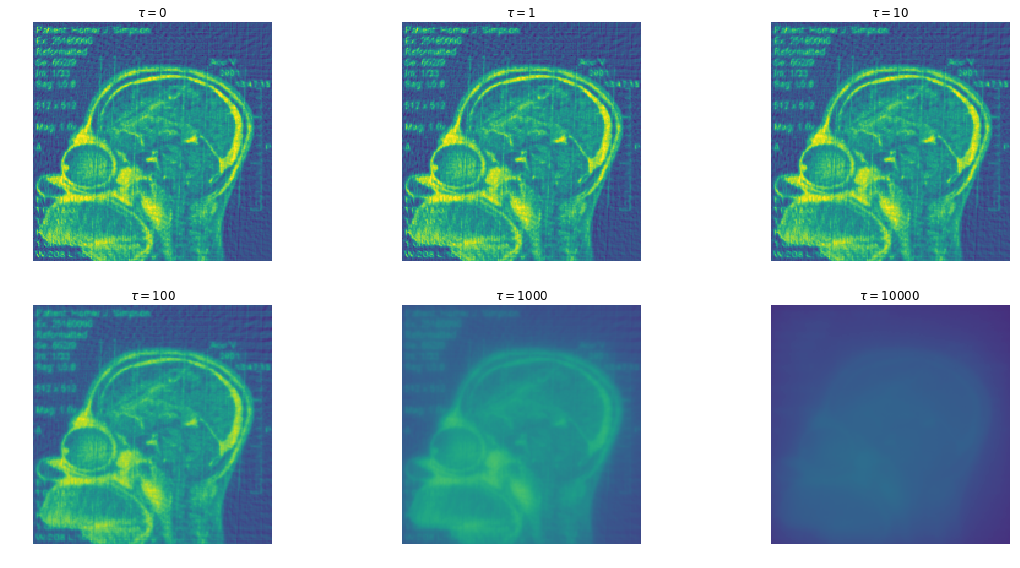

In [4]:
Np = 275
y = np.load('hs_tomography/y_195.npy')
alphas = np.load('hs_tomography/alphas_195.npy')

# numbers of projection angles to test
n_projections = 64

taus = [0, 1, 10, 100, 1000, 10000]

fig, axes = plt.subplots(2, 3, figsize = (16,8))

for n,t in enumerate(taus):
    # pick specified number of angles
    index = [int(np.ceil(len(alphas) * p/n_projections)) for p in range(n_projections)]
    alphas_sub = alphas[index]

    # collect corresponding measurements from y
    y_sub = []
    for i in index:
        y_sub.extend(y[i*Np : (i+1)*Np])
    
    y_sub = np.array(y_sub)
    
    if t > 0:
        y_sub = np.concatenate((y_sub, np.zeros(195*195)))
        
    # construct matrix and reconstruct image
    X = construct_X(195, alphas_sub, Np, t).tocsc()
    beta = lsqr(X, y_sub, atol = 1e-5, btol = 1e-5)[0].reshape(195,195)

    axes.flat[n].imshow(beta, vmin = 0, vmax = 255, interpolation = 'nearest')
    axes.flat[n].set_title('$\\tau=${}'.format(t)); axes.flat[n].axis('off')

fig.tight_layout()
plt.show()

## Gaussian Filter

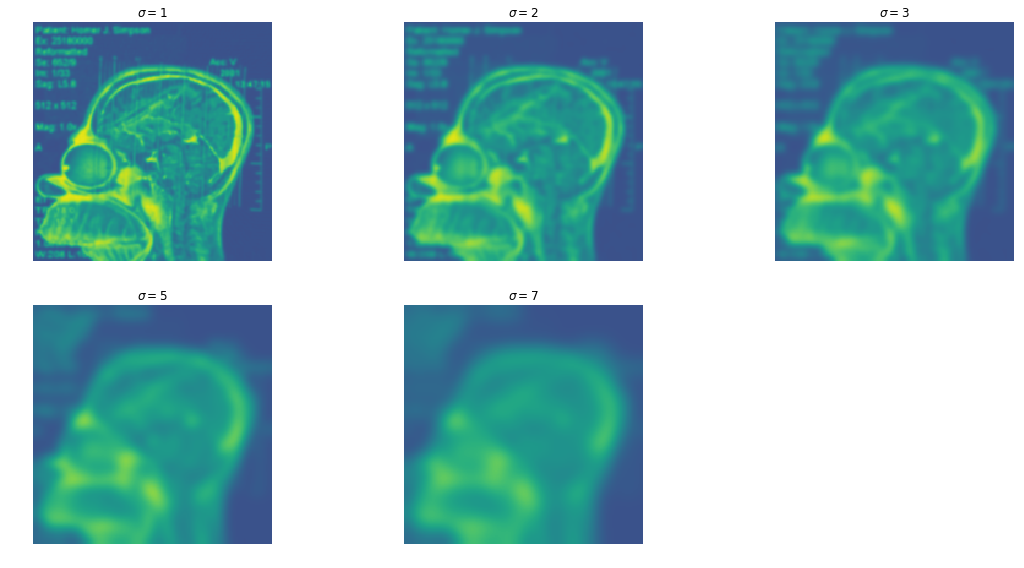

In [5]:
X = construct_X(195, alphas, Np).tocsc()
beta = lsqr(X, y, atol = 1e-5, btol = 1e-5)[0].reshape(195,195)

filters = [1, 2, 3, 5, 7]

fig, axes = plt.subplots(2, 3, figsize = (16,8))

for n,t in enumerate(filters):
    axes.flat[n].imshow(gaussian_filter(beta, sigma=t), vmin = 0, vmax = 255, interpolation = 'nearest')
    axes.flat[n].set_title('$\\sigma=${}'.format(t)); axes.flat[n].axis('off')

fig.delaxes(axes.flat[-1])
fig.tight_layout()
plt.show()

# 3 Automatic Feature Selection for Regression

## 3.1 Orthogonal Matching Pursuit Implementation

In [6]:
from sklearn.datasets import load_digits
from sklearn.model_selection import StratifiedKFold
import sklearn

digits = load_digits()

# print(digits.keys())

data = digits["data"]
images = digits["images"].reshape(-1,64)
target = digits["target"]
target_names = digits["target_names"]

mask17 = np.logical_or(target == 1, target == 7)

data17 = data[mask17]
target17 = target[mask17]
images17 = images[mask17]

target17[target17 == 1] = 1
target17[target17 == 7] = -1

cross_val = StratifiedKFold(2)
train_index, test_index = next(cross_val.split(images17, target17))

total_train, total_test = next(cross_val.split(images, target))

In [7]:
def omp_regression(X, y, T):
    X = np.copy(X)
    A = np.array([])
    B = np.arange(X.shape[1])
    
    residual = y
    
    for t in range(T):
        j = np.argmax(np.abs(np.dot(X.T, residual)))
        
        B = np.delete(B, np.argwhere(B == j))
        A = np.append(A, j)
        
        X[:,j] = 0
        
        beta = lsqr(X, y, atol=1e-5, btol=1e-5)[0]
        residual = y - X@beta
        
        yield beta

## 3.2 Classification with sparse LDA

### Data not standardized

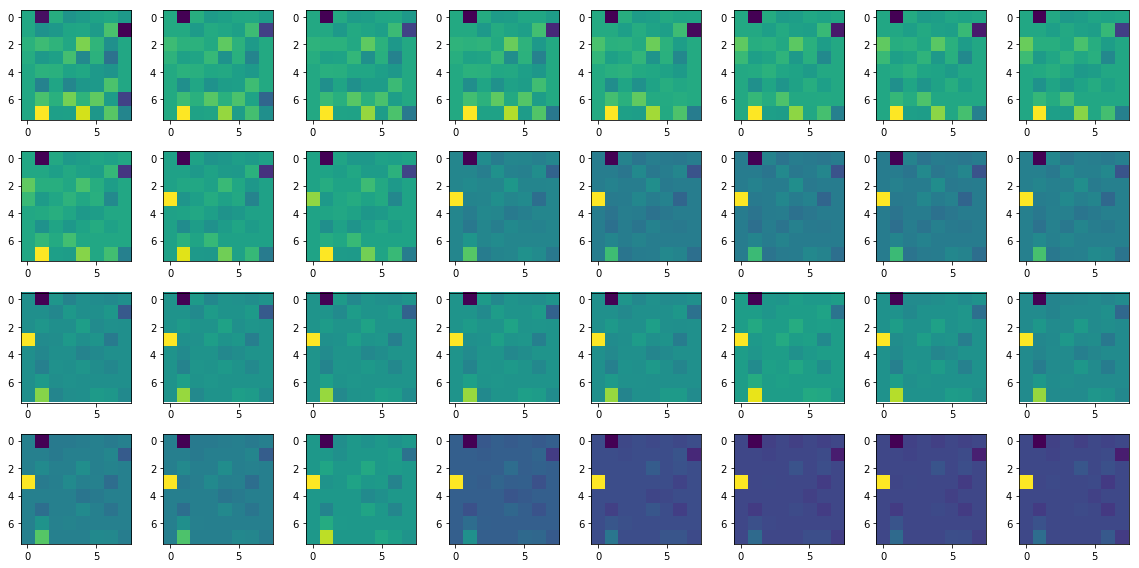

Error Rate
$t$            
0      0.011050
1      0.011050
2      0.011050
3      0.011050
4      0.011050
5      0.011050
6      0.011050
7      0.011050
8      0.011050
9      0.011050
10     0.011050
11     0.022099
12     0.016575
13     0.005525
14     0.005525
15     0.005525
16     0.005525
17     0.005525
18     0.005525
19     0.005525
20     0.005525
21     0.022099
22     0.016575
23     0.022099
24     0.011050
25     0.011050
26     0.016575
27     0.022099
28     0.049724
29     0.038674
30     0.044199
31     0.049724

In [8]:
betas = omp_regression(images17[train_index], target17[train_index], 32)

fig, axes = plt.subplots(4,8,figsize=(16,8))

error_rates = []
for n, beta in enumerate(betas):
    prediction = np.sign(np.sum(beta * images17[test_index], axis=-1))
    error_rate = (prediction != target17[test_index]).sum()/target17[test_index].shape[0]
    error_rates.append(error_rate)
    
    axes.flat[n].imshow(beta.reshape(8,8))
    
fig.tight_layout()
plt.show()
    
error_rates = pd.DataFrame(error_rates, columns=("Error Rate",))
error_rates.index.name = "$t$"
display(error_rates)

### Standardized Data

/home/tillb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


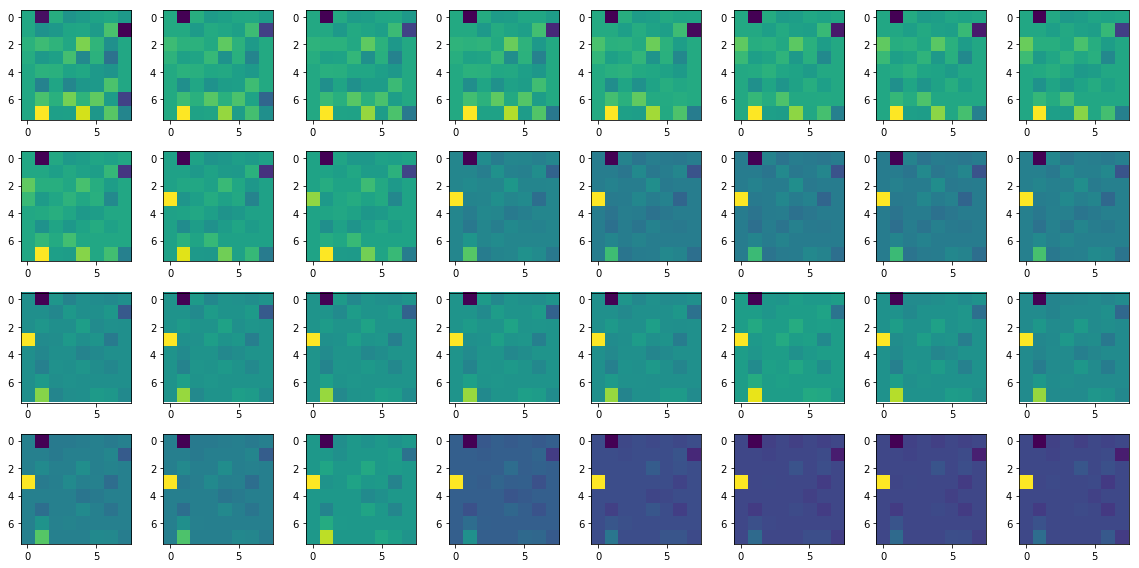

Error Rate
$t$            
0      0.011050
1      0.011050
2      0.011050
3      0.011050
4      0.011050
5      0.011050
6      0.011050
7      0.011050
8      0.011050
9      0.011050
10     0.011050
11     0.022099
12     0.016575
13     0.005525
14     0.005525
15     0.005525
16     0.005525
17     0.005525
18     0.005525
19     0.005525
20     0.005525
21     0.022099
22     0.016575
23     0.022099
24     0.011050
25     0.011050
26     0.016575
27     0.022099
28     0.049724
29     0.038674
30     0.044199
31     0.049724

In [9]:
images17_std = (images17 - images17.mean(axis=0))/images17.std(axis=0)
betas = omp_regression(images17[train_index], target17[train_index], 32)

fig, axes = plt.subplots(4,8,figsize=(16,8))

error_rates = []
for n, beta in enumerate(betas):
    prediction = np.sign(np.sum(beta * images17[test_index], axis=-1))
    error_rate = (prediction != target17[test_index]).sum()/target17[test_index].shape[0]
    error_rates.append(error_rate)
    
    axes.flat[n].imshow(beta.reshape(8,8))
    
fig.tight_layout()
plt.show()
    
error_rates = pd.DataFrame(error_rates, columns=("Error Rate",))
error_rates.index.name = "$t$"
display(error_rates)

## 3.3 One-against-the-rest classification

In [10]:
from collections import deque

class OneAgainstRest:
    def __init__(self):
        pass
    
    def fit(self, X, y, T):
        self.classes = np.unique(y)
        self.betas = np.array([], dtype=np.float32).reshape(0, X.shape[1])
        
        for c in self.classes:
            reference = np.ones_like(y)
            reference[y != c] = -1
            beta = deque(omp_regression(X, reference, T), maxlen=1).pop()
            self.betas = np.vstack((self.betas, beta))
            
    def predict(self, X):
        classes = np.append(self.classes, 10)
        predictions = np.sum(self.betas * X[:,np.newaxis,:], axis=-1)
        predictions = np.concatenate((predictions, -np.inf * np.ones(X.shape[0]).reshape(-1,1)), axis=1)
        predictions[np.all(predictions < 0, axis=1)][:,10] = np.inf
        
        return classes[np.argmax(predictions, axis=-1)]
        
classifier = OneAgainstRest()
classifier.fit(images[total_train], target[total_train], 7)
prediction = classifier.predict(images[total_test])
pd.crosstab(target[total_test], prediction, rownames=['Actual'], colnames=['Predicted'])

Predicted   0   1   2   3   4   5   6   7   8   9
Actual                                           
0          89   0   0   0   0   0   0   0   0   0
1           0  83   6   0   0   1   0   0   1   0
2           0   4  79   1   0   0   0   0   5   0
3           0   3   1  82   0   0   1   1   1   3
4           0   5   0   0  81   1   0   3   1   0
5           3   0   0   0   0  84   0   1   1   2
6           3   0   0   0   0   2  86   0   0   0
7           3   0   0   2   0   2   0  81   0   2
8           0  13   0   0   0   0   7   0  67   0
9           0   4   0   1   2   3   0   5   8  67

Unfortunately we did not manage to get the algorithm to
predict ```'undefined'```.